in this notebook different training parameters will be compared.\
firstly training with different training set sizes is compared.

In [9]:
import cv2
from ultralytics import YOLO
import numpy as np
import time
import os
import csv
import torch
import sys
from matplotlib import pyplot as plt
import json

In [10]:
def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) of two bounding boxes.

    Parameters:
    - box1: Tuple or List representing (x1, y1, x2, y2) of the first box.
    - box2: Tuple or List representing (x1, y1, x2, y2) of the second box.

    Returns:
    - IoU: Intersection over Union.
    """

    # Extract coordinates
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2

    # Calculate intersection coordinates
    x_intersection = max(0, min(x2_1, x2_2) - max(x1_1, x1_2))
    y_intersection = max(0, min(y2_1, y2_2) - max(y1_1, y1_2))

    # Calculate areas of boxes and intersection
    area_box1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area_box2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    area_intersection = x_intersection * y_intersection

    # Calculate Union
    area_union = area_box1 + area_box2 - area_intersection

    # Calculate IoU
    iou = area_intersection / (area_union + 1e-10)  # Add a small epsilon to avoid division by zero

    return iou

# Example usage:
box1 = (0, 0, 4, 4)
box2 = (2, 2, 6, 6)

iou = calculate_iou(box1, box2)
print(f"IoU: {iou}")


IoU: 0.14285714285663267


In [11]:
def test(model):
    overal_digits = 0
    overal_predicted_digits = 0
    overal_correct_digits = 0
    overal_numbers = 0
    overal_correct_numbers = 0
    with open('test_results_5000_images.csv', 'w', newline='') as csv_file:
    
        starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
        rep = 0
        dummy_input = torch.randn(1, 3,224,224, dtype=torch.float).to(device)
        #GPU-WARM-UP
        for _ in range(10):
            _ = model(dummy_input)
        timings = []
    
        
        writer = csv.writer(csv_file)
        field = ["filename", "backnumber","predicted_number", "amount_of_numbers","digits_predicted", "number_predicted_correct", "number_of_predicted_digits", "inference_time"]
        writer.writerow(field)
        progress = 0
        for file in os.listdir(os.path.join('datasets','test', 'images')):
    
            
            img = cv2.imread(os.path.join('datasets','test','images', file))
            starter.record()
            results = model(img, verbose=False)
            ender.record()
    
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings.append(curr_time)
            predicted_digits = []
            average_x = []
            result = results[0].boxes
            digits_to_discard = []
            boxes = []
            for i in range(len(result.cls)):
                for j in range(i+1, len(result.cls)):
                    box1 = (result.xyxy[i][0].item(), result.xyxy[i][1].item(), result.xyxy[i][2].item(), result.xyxy[i][3].item())
                    box2 = (result.xyxy[j][0].item(), result.xyxy[j][1].item(), result.xyxy[j][2].item(), result.xyxy[j][3].item())
                    iou = calculate_iou(box1, box2)
                    if iou > 0.5:
                        if result.conf[i].item() > result.conf[j].item():
                            digits_to_discard.append(j)
                        else:
                            digits_to_discard.append(i)
                        
            for j in range(len(result.cls)):
                if j not in digits_to_discard:
                    predicted_digits.append(int(result.cls[j].item()))
                    boxes.append( (result.xyxy[j][0].item(), result.xyxy[j][1].item(), result.xyxy[j][2].item(), result.xyxy[j][3].item()))
                    average_x.append((result.xyxy[j][2].item()+result.xyxy[j][0].item())/2)
                
            predicted_digits = [x for _,x in sorted(zip(average_x,predicted_digits))]
            predicted_boxes = [x for _,x in sorted(zip(average_x,boxes))]
            predicted_number ="".join([str(i) for i in predicted_digits])
            
            filename = file.split('.')[0] +'.' + file.split('.')[1] +'.txt'
            existing_filepath = os.path.join('datasets','test','labels', filename)
            if os.path.exists(existing_filepath): 
                # Using readlines()
                file1 = open(existing_filepath, 'r')
                Lines = file1.readlines()
                boxes = []
                count = 0
                number = ''
                digits = []
                average_x = []
                height, width, _ = img.shape
                # Strips the newline character
                for line in Lines:
                    count += 1
                    digits.append(line.split(' ')[0])
                    average_x.append(line.split(' ')[1])
                    box = ((float(line.split(' ')[1]) - float(line.split(' ')[3])/2)*width,(float(line.split(' ')[2]) - float(line.split(' ')[4])/2)*height, (float(line.split(' ')[1]) + float(line.split(' ')[3])/2)*width,(float(line.split(' ')[2]) + float(line.split(' ')[4])/2)*height)
                    boxes.append(box)
                digits = [x for _, x in sorted(zip(average_x, digits))]
                boxes = [x for _, x in sorted(zip(average_x, boxes))]
                number ="".join([str(i) for i in digits])
                correctly_predicted_digits = 0
                already_found = []
                for i in range(len(predicted_digits)):
                    for j in range(len(digits)):
                        if j not in already_found:
                            if calculate_iou(predicted_boxes[i], boxes[j]) >0.5:
                                if predicted_digits[i] == int(digits[j]):
                                    correctly_predicted_digits += 1
                                    already_found.append(j)
    
                overal_digits+= count
                overal_numbers+= 1
                overal_predicted_digits += len(predicted_digits)
                overal_correct_digits += correctly_predicted_digits
                if number == predicted_number:
                    overal_correct_numbers += 1
                field = [filename, number,predicted_number, str(count), correctly_predicted_digits,number == predicted_number, predicted_digits, curr_time]
                writer.writerow(field)
                progress+=1
            if progress % 500 == 0:
                print(progress)
            """if progress >1:
                break"""
    return (overal_digits, overal_predicted_digits, overal_correct_digits, overal_numbers, overal_correct_numbers, np.sum(np.array(timings))/len(timings))

## training with 5000 images

In [12]:
model_path = "runs/detect/train6/weights/best.pt"
recognition_model = YOLO(model_path)

device = torch.device("cuda")
a = recognition_model.to(device)

In [13]:

(overal_digits, overal_predicted_digits, overal_correct_digits, overal_numbers, overal_correct_numbers, time) = test(recognition_model)
print(f'the total number of digits in the testing dataset: {overal_digits}')
print(f'the number of digits that where predicted: {overal_predicted_digits}')
print(f'the digits that were predicted correctly: {overal_correct_digits}')
print(f'the amount of numbers that were evaluated: {overal_numbers}')
print(f'the numbers that werepredicted correct entirely: {overal_correct_numbers}')
print(f'average inference time: {time}')


WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.304110527038574. Dividing input by 255.
0: 224x224 1 0, 1 1, 1 7, 403.4ms
Speed: 0.1ms preprocess, 403.4ms inference, 17.2ms postprocess per image at shape (1, 3, 224, 224)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.304110527038574. Dividing input by 255.
0: 224x224 1 0, 1 1, 1 7, 90.4ms
Speed: 0.1ms preprocess, 90.4ms inference, 3.0ms postprocess per image at shape (1, 3, 224, 224)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.304110527038574. Dividing input by 255.
0: 224x224 1 0, 1 1, 1 7, 117.2ms
Speed: 0.4ms preprocess, 117.2ms inference, 9.0ms postprocess per image at shape (1, 3, 224, 224)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.304110527038574. Dividing input by 255.
0: 224x224 1 0, 1 1, 1 7, 105.7ms
Speed: 0.1ms preprocess, 105.7ms inference, 12.1ms postprocess per image at shape (1, 3, 22

## training with 10000 images

In [16]:
model_path = "runs/detect/train7/weights/best.pt"
recognition_model = YOLO(model_path)

device = torch.device("cuda")
a = recognition_model.to(device)

In [17]:

(overal_digits, overal_predicted_digits, overal_correct_digits, overal_numbers, overal_correct_numbers, time) = test(recognition_model)
print(f'the total number of digits in the testing dataset: {overal_digits}')
print(f'the number of digits that where predicted: {overal_predicted_digits}')
print(f'the digits that were predicted correctly: {overal_correct_digits}')
print(f'the amount of numbers that were evaluated: {overal_numbers}')
print(f'the numbers that werepredicted correct entirely: {overal_correct_numbers}')
print(f'average inference time: {time}')


WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.510932922363281. Dividing input by 255.
0: 224x224 (no detections), 142.2ms
Speed: 0.5ms preprocess, 142.2ms inference, 24.1ms postprocess per image at shape (1, 3, 224, 224)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.510932922363281. Dividing input by 255.
0: 224x224 (no detections), 18.4ms
Speed: 0.0ms preprocess, 18.4ms inference, 5.5ms postprocess per image at shape (1, 3, 224, 224)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.510932922363281. Dividing input by 255.
0: 224x224 (no detections), 13.7ms
Speed: 0.0ms preprocess, 13.7ms inference, 20.5ms postprocess per image at shape (1, 3, 224, 224)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.510932922363281. Dividing input by 255.
0: 224x224 (no detections), 27.1ms
Speed: 0.0ms preprocess, 27.1ms inference, 1.8ms postprocess per image at shape (1, 3

## training with 15000 images

In [18]:
model_path = "runs/detect/train8/weights/best.pt"
recognition_model = YOLO(model_path)

device = torch.device("cuda")
a = recognition_model.to(device)

In [19]:

(overal_digits, overal_predicted_digits, overal_correct_digits, overal_numbers, overal_correct_numbers, time) = test(recognition_model)
print(f'the total number of digits in the testing dataset: {overal_digits}')
print(f'the number of digits that where predicted: {overal_predicted_digits}')
print(f'the digits that were predicted correctly: {overal_correct_digits}')
print(f'the amount of numbers that were evaluated: {overal_numbers}')
print(f'the numbers that werepredicted correct entirely: {overal_correct_numbers}')
print(f'average inference time: {time}')


WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.67950963973999. Dividing input by 255.
0: 224x224 (no detections), 55.8ms
Speed: 0.0ms preprocess, 55.8ms inference, 5.3ms postprocess per image at shape (1, 3, 224, 224)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.67950963973999. Dividing input by 255.
0: 224x224 (no detections), 11.4ms
Speed: 0.1ms preprocess, 11.4ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 224)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.67950963973999. Dividing input by 255.
0: 224x224 (no detections), 11.3ms
Speed: 0.0ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 224)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.67950963973999. Dividing input by 255.
0: 224x224 (no detections), 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 2

## training with 20000 images

In [22]:
model_path = "runs/detect/train9/weights/best.pt"
recognition_model = YOLO(model_path)

device = torch.device("cuda")
a = recognition_model.to(device)

In [23]:

(overal_digits, overal_predicted_digits, overal_correct_digits, overal_numbers, overal_correct_numbers, time) = test(recognition_model)
print(f'the total number of digits in the testing dataset: {overal_digits}')
print(f'the number of digits that where predicted: {overal_predicted_digits}')
print(f'the digits that were predicted correctly: {overal_correct_digits}')
print(f'the amount of numbers that were evaluated: {overal_numbers}')
print(f'the numbers that werepredicted correct entirely: {overal_correct_numbers}')
print(f'average inference time: {time}')


WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.398976802825928. Dividing input by 255.
0: 224x224 (no detections), 264.3ms
Speed: 0.5ms preprocess, 264.3ms inference, 76.8ms postprocess per image at shape (1, 3, 224, 224)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.398976802825928. Dividing input by 255.
0: 224x224 (no detections), 69.8ms
Speed: 0.0ms preprocess, 69.8ms inference, 9.8ms postprocess per image at shape (1, 3, 224, 224)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.398976802825928. Dividing input by 255.
0: 224x224 (no detections), 62.0ms
Speed: 0.1ms preprocess, 62.0ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 224)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.398976802825928. Dividing input by 255.
0: 224x224 (no detections), 30.1ms
Speed: 0.0ms preprocess, 30.1ms inference, 4.2ms postprocess per image at shape (1, 3,

## training with 25000 images

In [24]:
model_path = "runs/detect/train11/weights/best.pt"
recognition_model = YOLO(model_path)

device = torch.device("cuda")
a = recognition_model.to(device)

In [25]:

(overal_digits, overal_predicted_digits, overal_correct_digits, overal_numbers, overal_correct_numbers, time) = test(recognition_model)
print(f'the total number of digits in the testing dataset: {overal_digits}')
print(f'the number of digits that where predicted: {overal_predicted_digits}')
print(f'the digits that were predicted correctly: {overal_correct_digits}')
print(f'the amount of numbers that were evaluated: {overal_numbers}')
print(f'the numbers that werepredicted correct entirely: {overal_correct_numbers}')
print(f'average inference time: {time}')


WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.449341773986816. Dividing input by 255.
0: 224x224 (no detections), 115.0ms
Speed: 0.4ms preprocess, 115.0ms inference, 21.6ms postprocess per image at shape (1, 3, 224, 224)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.449341773986816. Dividing input by 255.
0: 224x224 (no detections), 9.0ms
Speed: 0.4ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 224)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.449341773986816. Dividing input by 255.
0: 224x224 (no detections), 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 224)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.449341773986816. Dividing input by 255.
0: 224x224 (no detections), 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 224

## plot how more training data improves model

### single digit level

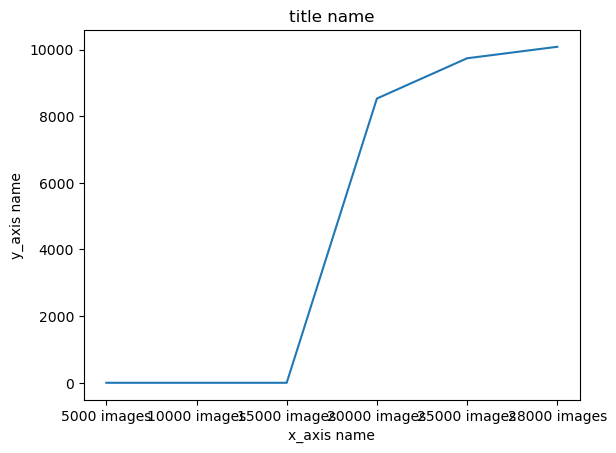

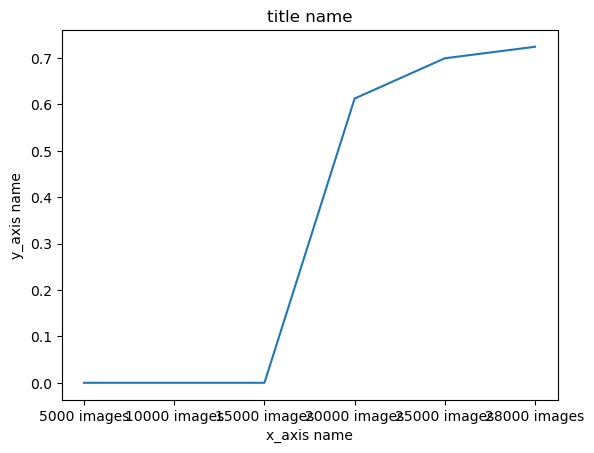

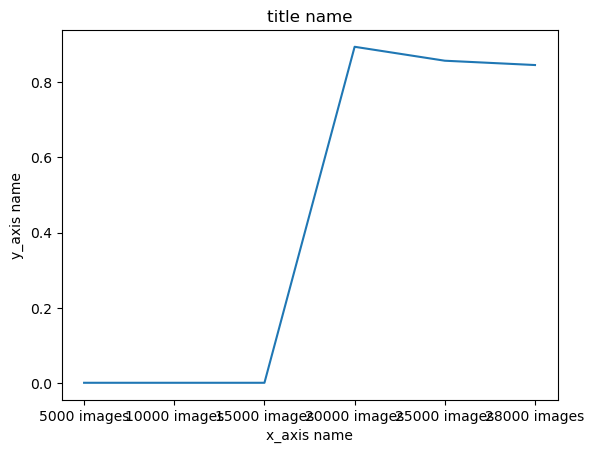

In [74]:
def calculate_precision_and_recall(correct, predictions,total):
    precision = correct/predictions if predictions != 0 else 0
    recall = correct/total if total != 0 else 0
    return precision, recall


precisions = []
recalls = []
correct_digits = []
labels= ['5000 images','10000 images', '15000 images', '20000 images', '25000 images', '28000 images']
total_digits = 13920


# for 5000 images
digits_predicted_5000 = 757
correct_digits_5000 = 0
correct_digits.append(correct_digits_5000)
precision_5000, recall_5000 = calculate_precision_and_recall(correct_digits_5000,digits_predicted_5000, total_digits)
precisions.append(precision_5000)
recalls.append(recall_5000)
# for 10000 images
digits_predicted_10000 = 146
correct_digits_10000 = 0
correct_digits.append(correct_digits_10000)
precision_10000, recall_10000 = calculate_precision_and_recall(correct_digits_10000,digits_predicted_10000, total_digits)
precisions.append(precision_10000)
recalls.append(recall_10000)
# for 15000 images
digits_predicted_15000 = 0
correct_digits_15000 = 0
correct_digits.append(correct_digits_15000)
precision_15000, recall_15000 = calculate_precision_and_recall(correct_digits_15000,digits_predicted_15000, total_digits)
precisions.append(precision_15000)
recalls.append(recall_15000)
# for 20000 images
digits_predicted_20000 = 9532
correct_digits_20000 = 8529
correct_digits.append(correct_digits_20000)
precision_20000, recall_20000 = calculate_precision_and_recall(correct_digits_20000,digits_predicted_20000, total_digits)
precisions.append(precision_20000)
recalls.append(recall_20000)
# for 25000 images
digits_predicted_25000 = 11353
correct_digits_25000 = 9737
correct_digits.append(correct_digits_25000)
precision_25000, recall_25000 = calculate_precision_and_recall(correct_digits_25000,digits_predicted_25000, total_digits)
precisions.append(precision_25000)
recalls.append(recall_25000)
# for 28000 images
digits_predicted_28000 = 11915
correct_digits_28000 = 10082
correct_digits.append(correct_digits_28000)
precision_28000, recall_28000 = calculate_precision_and_recall(correct_digits_28000,digits_predicted_28000, total_digits)
precisions.append(precision_28000)
recalls.append(recall_28000)

# for original model with trained with image size 450
digits_predicted_28000 = 11915
correct_digits_28000 = 10082
correct_digits.append(correct_digits_28000)
precision_28000, recall_28000 = calculate_precision_and_recall(correct_digits_28000,digits_predicted_28000, total_digits)
precisions.append(precision_28000)
recalls.append(recall_28000)

plt.plot(labels, correct_digits)
plt.title('title name')
plt.xlabel('x_axis name')
plt.ylabel('y_axis name')
plt.show()

plt.plot(labels, recalls)
plt.title('title name')
plt.xlabel('x_axis name')
plt.ylabel('y_axis name')
plt.show()

plt.plot(labels, precisions)
plt.title('title name')
plt.xlabel('x_axis name')
plt.ylabel('y_axis name')
plt.show()

## try setting training size of images to max size of image in train dataset
see model_training for explanation why preprocessing myself would not give any benefit

In [20]:
max_h = 0
max_w = 0
for file in os.listdir(os.path.join('datasets','train', 'images')):
    img = cv2.imread(os.path.join('datasets','train','images', file))
    h,w,_ = img.shape
    if h>max_h:
        max_h = h
    if w>max_w:
        max_w = w
    

In [21]:
print(f'The max image dimensions could be ({max_h}, {max_w})')

The max image dimensions could be (377, 440)


In [ ]:
""" this is not necessary as preprocessing myself doesn't seem beneficial. see model.training.py
def test2(model):
    overal_digits = 0
    overal_predicted_digits = 0
    overal_correct_digits = 0
    overal_numbers = 0
    overal_correct_numbers = 0
    with open('test_results_450,450_images.csv', 'w', newline='') as csv_file:
    
        starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
        rep = 0
        dummy_input = torch.randn(1, 3,224,224, dtype=torch.float).to(device)
        #GPU-WARM-UP
        for _ in range(10):
            _ = model(dummy_input,imgsz=450, verbose=False)
        timings = []
    
        
        writer = csv.writer(csv_file)
        field = ["filename", "backnumber","predicted_number", "amount_of_numbers","digits_predicted", "number_predicted_correct", "number_of_predicted_digits", "inference_time"]
        writer.writerow(field)
        progress = 0
        for file in os.listdir(os.path.join('datasets','test', 'images')):
    
            
            img = cv2.imread(os.path.join('datasets','test','images', file))
            starter.record()
            new_image = np.zeros((450,450,3), dtype = int)
            h,w, _ = img.shape
            added_h = 0
            added_w = 0
            if h <450:
                added_h = 450-h
                if w<450:
                    added_w = 450-w
                else:
                    new_image = np.zeros((450,w,3),  dtype = int)
            else:
                if w<450:
                    added_w = 450-w
                    new_image = np.zeros((h,450,3),  dtype = int)
                else:
                    new_image = np.zeros((h,w,3), dtype = int)
            new_image[added_h//2: added_h//2+h, added_w//2: added_w//2+w] = img
            results = model(img, imgsz=450, verbose=False)
            ender.record()
    
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings.append(curr_time)
            predicted_digits = []
            average_x = []
            result = results[0].boxes
            digits_to_discard = []
            boxes = []
            for i in range(len(result.cls)):
                for j in range(i+1, len(result.cls)):
                    box1 = (result.xyxy[i][0].item(), result.xyxy[i][1].item(), result.xyxy[i][2].item(), result.xyxy[i][3].item())
                    box2 = (result.xyxy[j][0].item(), result.xyxy[j][1].item(), result.xyxy[j][2].item(), result.xyxy[j][3].item())
                    iou = calculate_iou(box1, box2)
                    if iou > 0.5:
                        if result.conf[i].item() > result.conf[j].item():
                            digits_to_discard.append(j)
                        else:
                            digits_to_discard.append(i)
                        
            for j in range(len(result.cls)):
                if j not in digits_to_discard:
                    predicted_digits.append(int(result.cls[j].item()))
                    boxes.append( (result.xyxy[j][0].item(), result.xyxy[j][1].item(), result.xyxy[j][2].item(), result.xyxy[j][3].item()))
                    average_x.append((result.xyxy[j][2].item()+result.xyxy[j][0].item())/2)
                
            predicted_digits = [x for _,x in sorted(zip(average_x,predicted_digits))]
            predicted_boxes = [x for _,x in sorted(zip(average_x,boxes))]
            predicted_number ="".join([str(i) for i in predicted_digits])
            
            filename = file.split('.')[0] +'.' + file.split('.')[1] +'.txt'
            existing_filepath = os.path.join('datasets','test','labels', filename)
            if os.path.exists(existing_filepath): 
                # Using readlines()
                file1 = open(existing_filepath, 'r')
                Lines = file1.readlines()
                boxes = []
                count = 0
                number = ''
                digits = []
                average_x = []
                height, width, _ = img.shape
                # Strips the newline character
                for line in Lines:
                    count += 1
                    c, tw, th, bw, bh = line.strip().split(' ')
                    line = c+' '+str((float(tw)*w+added_w//2)/new_image.shape[1])+' '+str((float(th)*h+added_h//2)/new_image.shape[0])+' '+str((float(bw)*w)/new_image.shape[1])+' '+str((float(bh)*h)/new_image.shape[0])
                    digits.append(line.split(' ')[0])
                    average_x.append(line.split(' ')[1])
                    box = ((float(line.split(' ')[1]) - float(line.split(' ')[3])/2)*width,(float(line.split(' ')[2]) - float(line.split(' ')[4])/2)*height, (float(line.split(' ')[1]) + float(line.split(' ')[3])/2)*width,(float(line.split(' ')[2]) + float(line.split(' ')[4])/2)*height)
                    boxes.append(box)
                digits = [x for _, x in sorted(zip(average_x, digits))]
                boxes = [x for _, x in sorted(zip(average_x, boxes))]
                number ="".join([str(i) for i in digits])
                correctly_predicted_digits = 0
                already_found = []
                for i in range(len(predicted_digits)):
                    for j in range(len(digits)):
                        if j not in already_found:
                            if calculate_iou(predicted_boxes[i], boxes[j]) >0.5:
                                if predicted_digits[i] == int(digits[j]):
                                    correctly_predicted_digits += 1
                                    already_found.append(j)
    
                overal_digits+= count
                overal_numbers+= 1
                overal_predicted_digits += len(predicted_digits)
                overal_correct_digits += correctly_predicted_digits
                if number == predicted_number:
                    overal_correct_numbers += 1
                field = [filename, number,predicted_number, str(count), correctly_predicted_digits,number == predicted_number, predicted_digits, curr_time]
                writer.writerow(field)
                progress+=1
            if progress % 500 == 0:
                print(progress)
            if progress >1:
                break
    return (overal_digits, overal_predicted_digits, overal_correct_digits, overal_numbers, overal_correct_numbers, np.sum(np.array(timings))/len(timings))
    """

In [ ]:
"""model_path = "runs/detect/train11/weights/best.pt"
recognition_model = YOLO(model_path)

device = torch.device("cuda")
a = recognition_model.to(device)"""

In [ ]:

(overal_digits, overal_predicted_digits, overal_correct_digits, overal_numbers, overal_correct_numbers, time) = test(recognition_model)
print(f'the total number of digits in the testing dataset: {overal_digits}')
print(f'the number of digits that where predicted: {overal_predicted_digits}')
print(f'the digits that were predicted correctly: {overal_correct_digits}')
print(f'the amount of numbers that were evaluated: {overal_numbers}')
print(f'the numbers that werepredicted correct entirely: {overal_correct_numbers}')
print(f'average inference time: {time}')

## try model where image size for training was 450

In [37]:
def test2(model):
    overal_digits = 0
    overal_predicted_digits = 0
    overal_correct_digits = 0
    overal_numbers = 0
    overal_correct_numbers = 0
    with open('test_results_5000_images.csv', 'w', newline='') as csv_file:
    
        starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
        rep = 0
        dummy_input = torch.randn(1, 3,224,224, dtype=torch.float).to(device)
        #GPU-WARM-UP
        for _ in range(10):
            _ = model(dummy_input)
        timings = []
    
        
        writer = csv.writer(csv_file)
        field = ["filename", "backnumber","predicted_number", "amount_of_numbers","digits_predicted", "number_predicted_correct", "number_of_predicted_digits", "inference_time"]
        writer.writerow(field)
        progress = 0
        for file in os.listdir(os.path.join('datasets','test', 'images')):
    
            
            img = cv2.imread(os.path.join('datasets','test','images', file))
            starter.record()
            results = model(img, verbose=False, imgsz = 40)
            ender.record()
    
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings.append(curr_time)
            predicted_digits = []
            average_x = []
            result = results[0].boxes
            digits_to_discard = []
            boxes = []
            for i in range(len(result.cls)):
                for j in range(i+1, len(result.cls)):
                    box1 = (result.xyxy[i][0].item(), result.xyxy[i][1].item(), result.xyxy[i][2].item(), result.xyxy[i][3].item())
                    box2 = (result.xyxy[j][0].item(), result.xyxy[j][1].item(), result.xyxy[j][2].item(), result.xyxy[j][3].item())
                    iou = calculate_iou(box1, box2)
                    if iou > 0.5:
                        if result.conf[i].item() > result.conf[j].item():
                            digits_to_discard.append(j)
                        else:
                            digits_to_discard.append(i)
                        
            for j in range(len(result.cls)):
                if j not in digits_to_discard:
                    predicted_digits.append(int(result.cls[j].item()))
                    boxes.append( (result.xyxy[j][0].item(), result.xyxy[j][1].item(), result.xyxy[j][2].item(), result.xyxy[j][3].item()))
                    average_x.append((result.xyxy[j][2].item()+result.xyxy[j][0].item())/2)
                
            predicted_digits = [x for _,x in sorted(zip(average_x,predicted_digits))]
            predicted_boxes = [x for _,x in sorted(zip(average_x,boxes))]
            predicted_number ="".join([str(i) for i in predicted_digits])
            
            filename = file.split('.')[0] +'.' + file.split('.')[1] +'.txt'
            existing_filepath = os.path.join('datasets','test','labels', filename)
            if os.path.exists(existing_filepath): 
                # Using readlines()
                file1 = open(existing_filepath, 'r')
                Lines = file1.readlines()
                boxes = []
                count = 0
                number = ''
                digits = []
                average_x = []
                height, width, _ = img.shape
                # Strips the newline character
                for line in Lines:
                    count += 1
                    digits.append(line.split(' ')[0])
                    average_x.append(line.split(' ')[1])
                    box = ((float(line.split(' ')[1]) - float(line.split(' ')[3])/2)*width,(float(line.split(' ')[2]) - float(line.split(' ')[4])/2)*height, (float(line.split(' ')[1]) + float(line.split(' ')[3])/2)*width,(float(line.split(' ')[2]) + float(line.split(' ')[4])/2)*height)
                    boxes.append(box)
                digits = [x for _, x in sorted(zip(average_x, digits))]
                boxes = [x for _, x in sorted(zip(average_x, boxes))]
                number ="".join([str(i) for i in digits])
                correctly_predicted_digits = 0
                already_found = []
                for i in range(len(predicted_digits)):
                    for j in range(len(digits)):
                        if j not in already_found:
                            if calculate_iou(predicted_boxes[i], boxes[j]) >0.5:
                                if predicted_digits[i] == int(digits[j]):
                                    correctly_predicted_digits += 1
                                    already_found.append(j)
    
                overal_digits+= count
                overal_numbers+= 1
                overal_predicted_digits += len(predicted_digits)
                overal_correct_digits += correctly_predicted_digits
                if number == predicted_number:
                    overal_correct_numbers += 1
                field = [filename, number,predicted_number, str(count), correctly_predicted_digits,number == predicted_number, predicted_digits, curr_time]
                writer.writerow(field)
                progress+=1
            if progress % 500 == 0:
                print(progress)
            """if progress >1:
                break"""
    return (overal_digits, overal_predicted_digits, overal_correct_digits, overal_numbers, overal_correct_numbers, np.sum(np.array(timings))/len(timings))

In [38]:
model_path = "runs/detect/train12/weights/best.pt"
recognition_model = YOLO(model_path)

device = torch.device("cuda")
a = recognition_model.to(device)

In [39]:

(overal_digits, overal_predicted_digits, overal_correct_digits, overal_numbers, overal_correct_numbers, time) = test2(recognition_model)
print(f'the total number of digits in the testing dataset: {overal_digits}')
print(f'the number of digits that where predicted: {overal_predicted_digits}')
print(f'the digits that were predicted correctly: {overal_correct_digits}')
print(f'the amount of numbers that were evaluated: {overal_numbers}')
print(f'the numbers that werepredicted correct entirely: {overal_correct_numbers}')
print(f'average inference time: {time}')


WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.3410797119140625. Dividing input by 255.
0: 224x224 (no detections), 14.3ms
Speed: 0.0ms preprocess, 14.3ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 224)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.3410797119140625. Dividing input by 255.
0: 224x224 (no detections), 14.7ms
Speed: 0.0ms preprocess, 14.7ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 224)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.3410797119140625. Dividing input by 255.
0: 224x224 (no detections), 14.5ms
Speed: 0.0ms preprocess, 14.5ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 224)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.3410797119140625. Dividing input by 255.
0: 224x224 (no detections), 14.9ms
Speed: 0.0ms preprocess, 14.9ms inference, 1.1ms postprocess per image at shape (1, 3

## set agnostic_nms to true to see if it improves time

In [95]:
def test3(model):
    overal_digits = 0
    overal_predicted_digits = 0
    overal_correct_digits = 0
    overal_numbers = 0
    overal_correct_numbers = 0
    with open('test_results_5000_images.csv', 'w', newline='') as csv_file:
    
        starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
        rep = 0
        dummy_input = torch.randn(1, 3,224,224, dtype=torch.float).to(device)
        #GPU-WARM-UP
        for _ in range(10):
            _ = model(dummy_input)
        timings = []
    
        
        writer = csv.writer(csv_file)
        field = ["filename", "backnumber","predicted_number", "amount_of_numbers","digits_predicted", "number_predicted_correct", "number_of_predicted_digits", "inference_time"]
        writer.writerow(field)
        progress = 0
        for file in os.listdir(os.path.join('datasets','test', 'images')):
    
            
            img = cv2.imread(os.path.join('datasets','test','images', file))
            starter.record()
            results = model(img, verbose=False, agnostic_nms = True, iou = 0.5, stream = True)
            ender.record()
    
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings.append(curr_time)
            predicted_digits = []
            average_x = []
            for res in results:
                result = res.boxes
                digits_to_discard = []
                boxes = []
                            
                for j in range(len(result.cls)):
                    predicted_digits.append(int(result.cls[j].item()))
                    boxes.append( (result.xyxy[j][0].item(), result.xyxy[j][1].item(), result.xyxy[j][2].item(), result.xyxy[j][3].item()))
                    average_x.append((result.xyxy[j][2].item()+result.xyxy[j][0].item())/2)
                    
                predicted_digits = [x for _,x in sorted(zip(average_x,predicted_digits))]
                predicted_boxes = [x for _,x in sorted(zip(average_x,boxes))]
                predicted_number ="".join([str(i) for i in predicted_digits])
                
                filename = file.split('.')[0] +'.' + file.split('.')[1] +'.txt'
                existing_filepath = os.path.join('datasets','test','labels', filename)
                if os.path.exists(existing_filepath): 
                    # Using readlines()
                    file1 = open(existing_filepath, 'r')
                    Lines = file1.readlines()
                    boxes = []
                    count = 0
                    number = ''
                    digits = []
                    average_x = []
                    height, width, _ = img.shape
                    # Strips the newline character
                    for line in Lines:
                        count += 1
                        digits.append(line.split(' ')[0])
                        average_x.append(line.split(' ')[1])
                        box = ((float(line.split(' ')[1]) - float(line.split(' ')[3])/2)*width,(float(line.split(' ')[2]) - float(line.split(' ')[4])/2)*height, (float(line.split(' ')[1]) + float(line.split(' ')[3])/2)*width,(float(line.split(' ')[2]) + float(line.split(' ')[4])/2)*height)
                        boxes.append(box)
                    digits = [x for _, x in sorted(zip(average_x, digits))]
                    boxes = [x for _, x in sorted(zip(average_x, boxes))]
                    number ="".join([str(i) for i in digits])
                    correctly_predicted_digits = 0
                    already_found = []
                    for i in range(len(predicted_digits)):
                        for j in range(len(digits)):
                            if j not in already_found:
                                if calculate_iou(predicted_boxes[i], boxes[j]) >0.5:
                                    if predicted_digits[i] == int(digits[j]):
                                        correctly_predicted_digits += 1
                                        already_found.append(j)
        
                    overal_digits+= count
                    overal_numbers+= 1
                    overal_predicted_digits += len(predicted_digits)
                    overal_correct_digits += correctly_predicted_digits
                    if number == predicted_number:
                        overal_correct_numbers += 1
                    field = [filename, number,predicted_number, str(count), correctly_predicted_digits,number == predicted_number, predicted_digits, curr_time]
                    writer.writerow(field)
                    progress+=1
            if progress % 500 == 0:
                print(progress)
            """if progress >1:
                break"""
    return (overal_digits, overal_predicted_digits, overal_correct_digits, overal_numbers, overal_correct_numbers, np.sum(np.array(timings))/len(timings))

In [96]:
model_path = "runs/detect/train4/weights/best.pt"
recognition_model = YOLO(model_path)

device = torch.device("cuda")
a = recognition_model.to(device)

In [97]:

(overal_digits, overal_predicted_digits, overal_correct_digits, overal_numbers, overal_correct_numbers, time) = test3(recognition_model)
print(f'the total number of digits in the testing dataset: {overal_digits}')
print(f'the number of digits that where predicted: {overal_predicted_digits}')
print(f'the digits that were predicted correctly: {overal_correct_digits}')
print(f'the amount of numbers that were evaluated: {overal_numbers}')
print(f'the numbers that werepredicted correct entirely: {overal_correct_numbers}')
print(f'average inference time: {time}')

#stream gebruiken is awesome snel


WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.233923435211182. Dividing input by 255.
0: 224x224 (no detections), 11.8ms
Speed: 0.0ms preprocess, 11.8ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 224)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.233923435211182. Dividing input by 255.
0: 224x224 (no detections), 12.3ms
Speed: 0.0ms preprocess, 12.3ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 224)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.233923435211182. Dividing input by 255.
0: 224x224 (no detections), 11.1ms
Speed: 0.0ms preprocess, 11.1ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 224)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.233923435211182. Dividing input by 255.
0: 224x224 (no detections), 12.0ms
Speed: 0.0ms preprocess, 12.0ms inference, 0.8ms postprocess per image at shape (1, 3, 22

6000
